In [38]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

import matplotlib.pyplot as plt

# SHAP
import shap

# XGBoost (optional)
try:
    import xgboost as xgb
except Exception as e:
    xgb = None
    print("xgboost not available (import failed):", e)

In [39]:
# -------------------------------------------------------------------
# 1. Paths and basic loading
# -------------------------------------------------------------------
TRAIN_PATH = '../data/ML_data/train_panel_years_to_developed.csv'
TEST_PATH  = '../data/ML_data/predict_panel_features.csv'

target_col = 'years_to_developed'
top_k_features = 30   # number of top features to keep (change to 20–30 as you like)

df_train = pd.read_csv(TRAIN_PATH)
df_test  = pd.read_csv(TEST_PATH)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

# Separate features/target
X_full = df_train.drop(columns=[target_col])
y_full = df_train[target_col]
X_test_full = df_test.copy()


Train shape: (1882, 250)
Test shape : (4358, 249)


In [40]:
X_full.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [41]:
# -------------------------------------------------------------------
# 2. SHAP feature selection (on numeric features only)
#    -> to find features most associated with years_to_develop
# -------------------------------------------------------------------

numeric_features_all = X_full.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_features_all) == 0:
    raise ValueError("No numeric features found. You may need to encode categoricals first.")

X_num = X_full[numeric_features_all]
X_test_num = X_test_full[numeric_features_all]

# -------------------------------------------------------------------
# Use RandomForest for SHAP (to avoid XGBoost–SHAP version issues)
# -------------------------------------------------------------------
shap_model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
print("Using RandomForest for SHAP feature selection.")

# Fit model on all numeric features
shap_model.fit(X_num, y_full)

# To speed up SHAP, sample up to 1000 rows
sample_size = min(1000, len(X_num))
X_sample = X_num.sample(n=sample_size, random_state=42)

# SHAP TreeExplainer for tree models (RandomForest)
explainer = shap.TreeExplainer(shap_model)
shap_raw = explainer.shap_values(X_sample)

# Make sure we always get a 2D matrix: (n_samples, n_features)
if isinstance(shap_raw, list):
    # e.g. multiclass returns list; for regression we expect one element
    shap_matrix = shap_raw[0]
else:
    shap_matrix = shap_raw

# Mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_matrix).mean(axis=0)

shap_importance = (
    pd.DataFrame({
        "feature": numeric_features_all,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("Top 20 features by SHAP importance:")
display(shap_importance.head(20))

# Select top-k numeric features
top_features = shap_importance["feature"].head(top_k_features).tolist()
print(f"\nSelected top {len(top_features)} features for modeling:")
print(top_features)

# Subset data to selected features
X = X_full[top_features]
X_test = X_test_full[top_features]


Using RandomForest for SHAP feature selection.
Top 20 features by SHAP importance:
Top 20 features by SHAP importance:


,feature,mean_abs_shap
0,Fixed telephone subscriptions (per 100 people),5.101258
1,"Life expectancy at birth, female (years)",1.825546
2,"Population ages 80 and above, male (% of male ...",0.947358
3,Rural population (% of total population),0.609679
4,"Adolescent fertility rate (births per 1,000 wo...",0.540038
5,Urban population (% of total population),0.536614
6,"Official exchange rate (LCU per US$, period av...",0.439028
7,"Population ages 35-39, female (% of female pop...",0.431880
8,Total fisheries production (metric tons),0.420460
9,Population density (people per sq. km of land ...,0.330366



Selected top 30 features for modeling:
['Fixed telephone subscriptions (per 100 people)', 'Life expectancy at birth, female (years)', 'Population ages 80 and above, male (% of male population)', 'Rural population (% of total population)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Urban population (% of total population)', 'Official exchange rate (LCU per US$, period average)', 'Population ages 35-39, female (% of female population)', 'Total fisheries production (metric tons)', 'Population density (people per sq. km of land area)', 'Life expectancy at birth, total (years)', 'Year', 'Year.1', 'Agricultural land (% of land area)', 'Mortality rate, neonatal (per 1,000 live births)', 'GDP deflator (base year varies by country)', 'Consumer price index (2010 = 100)', 'Population, male (% of total population)', 'Rural population', 'Population, female (% of total population)', 'Population ages 75-79, male (% of male population)', 'Population ages 0-14, female (% of fema

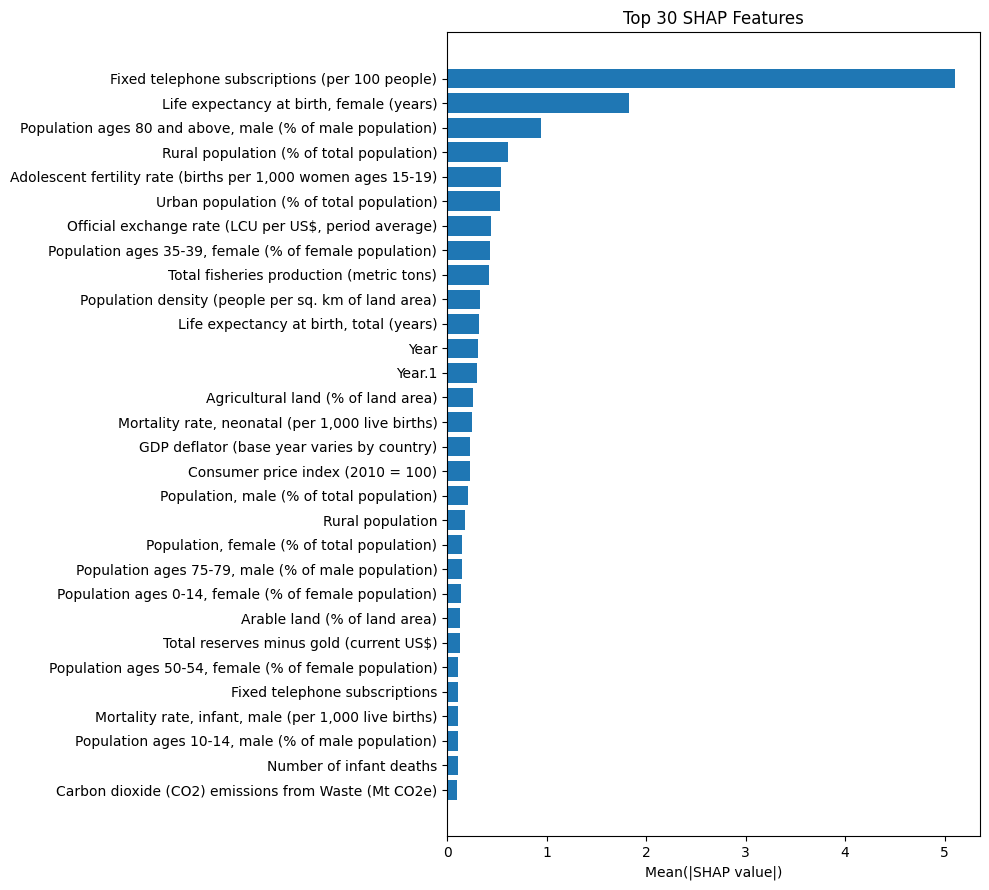

In [42]:
top_shap_plot = shap_importance.head(top_k_features)

plt.figure(figsize=(10, max(6, len(top_shap_plot) * 0.3)))
plt.barh(
    top_shap_plot["feature"][::-1],
    top_shap_plot["mean_abs_shap"][::-1],
)
plt.xlabel("Mean(|SHAP value|)")
plt.title(f"Top {top_k_features} SHAP Features")
plt.tight_layout()
plt.show()


In [43]:
# -------------------------------------------------------------------
# 3. Train/validation split
# -------------------------------------------------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y_full, test_size=0.2, random_state=42
)

print("Train subset shape:", X_tr.shape)
print("Validation subset shape:", X_val.shape)


Train subset shape: (1505, 30)
Validation subset shape: (377, 30)


In [44]:
# -------------------------------------------------------------------
# 4. Preprocessing (numeric + categorical, just in case)
# -------------------------------------------------------------------
numeric_features = X_tr.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_tr.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [45]:
# -------------------------------------------------------------------
# 5. Define models
# -------------------------------------------------------------------
models = {
    "linear_regression": LinearRegression(),
    "random_forest": RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )
}

if xgb is not None:
    models["xgboost"] = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

print("\nModels to train:", list(models.keys()))



Models to train: ['linear_regression', 'random_forest', 'xgboost']


In [46]:
# -------------------------------------------------------------------
# 6. Train models, evaluate on validation, predict on test
# -------------------------------------------------------------------
results = []
df_test_preds = df_test.copy()
os.makedirs("models", exist_ok=True)

for name, est in models.items():
    print("\n==============================")
    print("Training", name)
    print("==============================")

    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", est)
    ])

    # Fit
    pipe.fit(X_tr, y_tr)

    # Validation evaluation
    val_pred = pipe.predict(X_val)

    mse = mean_squared_error(y_val, val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    results.append({
        "model": name,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    })

    print(f"{name}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

    # Predict on test set
    try:
        test_pred = pipe.predict(X_test)
    except Exception as e:
        print("Prediction on test failed for", name, "->", e)
        test_pred = [None] * len(X_test)

    df_test_preds[f"pred_{name}"] = test_pred

    # Save model
    model_path = os.path.join("models", f"{name}.joblib")
    joblib.dump(pipe, model_path)
    print("Saved", name, "to", model_path)

# -------------------------------------------------------------------
# 7. Show results and (optionally) save predictions
# -------------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\nValidation performance (regression metrics):")
display(results_df)

# Optionally save test predictions
preds_path = "test_predictions_with_models.csv"
df_test_preds.to_csv(preds_path, index=False)
print("Saved test predictions to", preds_path)



Training linear_regression
linear_regression
  RMSE : 6.7719
  MAE  : 5.3347
  R²   : 0.7172
Saved linear_regression to models/linear_regression.joblib

Training random_forest
random_forest
  RMSE : 1.8373
  MAE  : 1.1961
  R²   : 0.9792
Saved random_forest to models/random_forest.joblib

Training xgboost
xgboost
  RMSE : 1.4355
  MAE  : 0.8881
  R²   : 0.9873
Saved xgboost to models/xgboost.joblib

Validation performance (regression metrics):


,model,rmse,mae,r2
0,linear_regression,6.771862,5.334685,0.717221
1,random_forest,1.837269,1.196085,0.979185
2,xgboost,1.435515,0.888150,0.987293


Saved test predictions to test_predictions_with_models.csv
